In [ ]:
#i use google colab and google drive so these first two cells are used for that porpuse

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = 'drive/MyDrive/colabs/SVHN/data/'

# HW3. SVHN


SVHN

[Google Street View House Number(SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/)

Much similar to MNIST(images of cropped digits), but SVHN contains much more labeled data (over 600,000 images) with real world problems of recognizing digits and numbers in *natural scene images*.

**Overview:**

1) Total 10 Classes, 1 for each digits i.e Label '9' for digit 9 and '10' for digit 0. 

2) 73,257 digits for training, 26,032 digits for testing.

3) Available in two differnet formats
Original images with bounding box available for each character (may contain multiple characters in same images).

MNIST like 32x32 cropped images having single character in each images.
Dataset is obtained from house numbers in Google Street View images.

Here we are classifying 32 x 32 cropped images given in format 2

In [4]:
import os
import tarfile
import torch
import numpy as np

import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
from torch.nn import AvgPool2d
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

!pip install torchsummary
from torchsummary import summary

from scipy.io import loadmat

Loading Dateset

In [5]:
#root='http://ufldl.stanford.edu/housenumbers/'
#root = '/data/'

transform = transforms.Compose([
                                transforms.CenterCrop((28, 28)),
                                transforms.ToTensor(),
                                #transforms.Normalize([0.5,],[0.5,])
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                                ])

train = torchvision.datasets.SVHN(root, split='train', transform=transform, target_transform=None, download=True)

train_dl = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

test_vi = torchvision.datasets.SVHN(root, split='test', transform=transforms.ToTensor(),download=True)
test_vii = torch.utils.data.DataLoader(test_vi, batch_size=128, shuffle=True)

test = torchvision.datasets.SVHN(root, split='test', transform=transform, target_transform=None, download=True)

test_dl = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

images_train, labels_train = next(iter(train_dl))
images_test, labels_test = next(iter(test_dl))
images_test_vi, labels_test_vi = next(iter(test_vi))

print("Shape of train inputs: ", images_train.shape, "; Shape of train labels: ", labels_train.shape)
print("Shape of test inputs: ",images_test.shape, "; Shape of test inputs: ", labels_test.shape)
print("Batch size = 128")

Using downloaded and verified file: drive/MyDrive/colabs/SVHN/data/train_32x32.mat
Using downloaded and verified file: drive/MyDrive/colabs/SVHN/data/test_32x32.mat
Using downloaded and verified file: drive/MyDrive/colabs/SVHN/data/test_32x32.mat
Shape of train inputs:  torch.Size([128, 3, 28, 28]) ; Shape of train labels:  torch.Size([128])
Shape of test inputs:  torch.Size([128, 3, 28, 28]) ; Shape of test inputs:  torch.Size([128])
Batch size = 128


**Visualization fo the data**

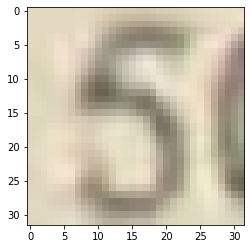

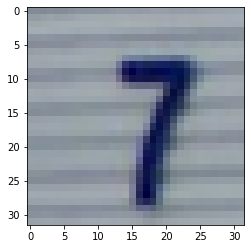

In [6]:
def show(image):
  ig, axes = plt.subplots()
  plt.imshow(image)
dataiter = iter(test_vii)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


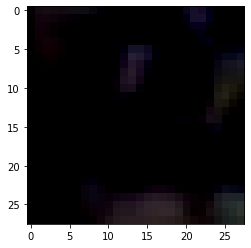

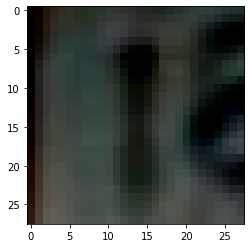

In [7]:
 dataiter = iter(test_dl)
images, labels = dataiter.next()
for i in range(113,115):
  img = images[i]
  img = img.numpy().transpose((1, 2, 0))
  show(img)

In [8]:
img, label = train[0]
print(img.shape, label)
img

torch.Size([3, 28, 28]) 1


tensor([[[-0.8745, -0.7647, -0.4980,  ..., -0.7412, -0.8039, -0.8196],
         [-0.8196, -0.8196, -0.5373,  ..., -0.6471, -0.5294, -0.6157],
         [-0.8275, -0.8588, -0.5922,  ..., -0.4745, -0.3569, -0.4039],
         ...,
         [-0.3569, -0.4431, -0.8196,  ..., -0.3333, -0.2078, -0.2000],
         [-0.3961, -0.4275, -0.6863,  ..., -0.2078, -0.1922, -0.1765],
         [-0.3569, -0.3725, -0.5137,  ..., -0.1765, -0.1843, -0.1843]],

        [[-0.8667, -0.7490, -0.5137,  ..., -0.8353, -0.7569, -0.7725],
         [-0.8588, -0.8039, -0.5451,  ..., -0.6314, -0.5843, -0.6627],
         [-0.8353, -0.8353, -0.5608,  ..., -0.4431, -0.4275, -0.4667],
         ...,
         [-0.4039, -0.4980, -0.8353,  ..., -0.2941, -0.2392, -0.2078],
         [-0.3647, -0.4196, -0.7020,  ..., -0.2314, -0.2000, -0.1843],
         [-0.3804, -0.3961, -0.5059,  ..., -0.1843, -0.1843, -0.1843]],

        [[-0.8196, -0.7647, -0.5765,  ..., -0.6471, -0.6941, -0.6471],
         [-0.8039, -0.8118, -0.5922,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


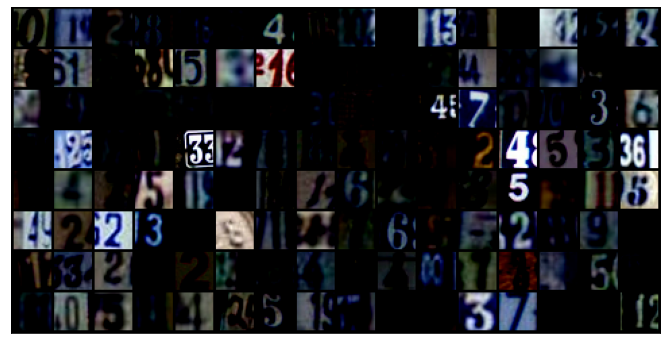

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [16]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

**Choosing hyperparameters**

In [17]:
num_epochs = 10 #in the end we conclude to avoid overfitting its better do 6 epochs
opt_func = torch.optim.Adam       ####select optimizer####
lr = 0.001
input_size = 2352
num_classes = 10

conv1_filter_shape = (3,3,32)
conv1_filter_shape = (3,3,64)
conv1_filter_shape = (3,3,128)
maxpool1_shape = (2,2)
dropout1_rate = 0.3
dropout2_rate = 0.4


In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(test_dl, device)

## Convolution Neural Net

In [19]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(dropout1_rate),
            
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(dropout1_rate),
            
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout1_rate),
            
            nn.Flatten(),
            nn.Linear(in_features=128*7*7, out_features=128),
            nn.Dropout(dropout2_rate),
            nn.Linear(in_features=128, out_features=10),


        )
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
 model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout2d(p=0.3, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.3, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Dropout2d(p=0.3, inplace=False)
    (17): Flatten(start_dim=1, 

In [21]:
model = to_device(CnnModel(), device)

In [22]:
summary(model, input_size=(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 32, 28, 28]           9,248
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
         Dropout2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          18,496
              ReLU-9           [-1, 64, 14, 14]               0
        MaxPool2d-10             [-1, 64, 7, 7]               0
        Dropout2d-11             [-1, 64, 7, 7]               0
           Conv2d-12            [-1, 128, 7, 7]          73,856
             ReLU-13            [-1, 128, 7, 7]               0
      BatchNorm2d-14            [-1, 12

In [23]:
print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

1054634
1054634


In [24]:
history = evaluate(model, val_dl)
history

{'val_acc': 0.0913628414273262, 'val_loss': 2.2983438968658447}

**In this part our performance will be evalualted**

In [25]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8035, val_loss: 0.3952, val_acc: 0.8839
Epoch [1], train_loss: 0.4062, val_loss: 0.3075, val_acc: 0.9115
Epoch [2], train_loss: 0.3415, val_loss: 0.2793, val_acc: 0.9226
Epoch [3], train_loss: 0.3083, val_loss: 0.2608, val_acc: 0.9286
Epoch [4], train_loss: 0.2809, val_loss: 0.2540, val_acc: 0.9304
Epoch [5], train_loss: 0.2622, val_loss: 0.2582, val_acc: 0.9290
Epoch [6], train_loss: 0.2511, val_loss: 0.2458, val_acc: 0.9331
Epoch [7], train_loss: 0.2324, val_loss: 0.2556, val_acc: 0.9310
Epoch [8], train_loss: 0.2233, val_loss: 0.2496, val_acc: 0.9341
Epoch [9], train_loss: 0.2101, val_loss: 0.2446, val_acc: 0.9356
CPU times: user 4min 7s, sys: 2.75 s, total: 4min 10s
Wall time: 4min 10s


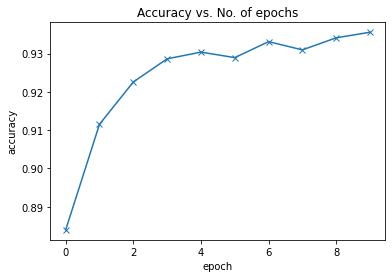

In [26]:
plot_accuracies(history)

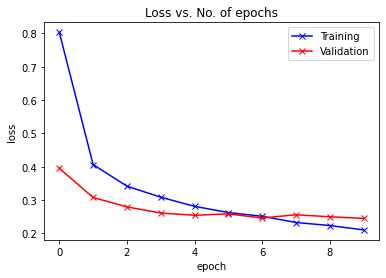

In [27]:
plot_losses(history)

### based on this plot its better to stop the network in epoch 5 or 6 but we do 10 epoch to showin our conclusion 

In [28]:
torch.save(model.state_dict(), 'svhn_cnn.pth')

### based on this plot its better to stop the network in epoch 5 or 6 but we do 10 epoch to showin our conclusion 
### validation accuracy is 93.56%